# Clasificación de grafos con redout Max

## Dataset MUTAG

In [29]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/')
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import *
from src.fspool import FSPool
from torch_scatter import scatter
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,DenseGraphConv, dense_mincut_pool
from torch_geometric.nn import global_mean_pool, global_max_pool,global_sort_pool
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
#torch.manual_seed(12345)
#print(f'Number of training graphs: {len(train_dataset)}')
#print(f'Number of test graphs: {len(test_dataset)}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [30]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(dataset[:150], batch_size=20, shuffle=True)
test_loader = DataLoader(dataset[150:], batch_size=20, shuffle=False)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 772], x=[347, 7], edge_attr=[772, 4], y=[20], batch=[347], ptr=[21])

Step 2:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 768], x=[348, 7], edge_attr=[768, 4], y=[20], batch=[348], ptr=[21])

Step 3:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 766], x=[351, 7], edge_attr=[766, 4], y=[20], batch=[351], ptr=[21])

Step 4:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 864], x=[385, 7], edge_attr=[864, 4], y=[20], batch=[385], ptr=[21])

Step 5:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 776], x=[354, 7], edge_attr=[776, 4], y=[20], batch=[354], ptr=[21])

Step 6:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 822], x=[372, 7], edge_attr=[822, 4], y=[20], batch=[372], ptr=[21])

Step 7:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 766], x=[346, 7], edge_attr=[766, 4], y=[20], batch=[34

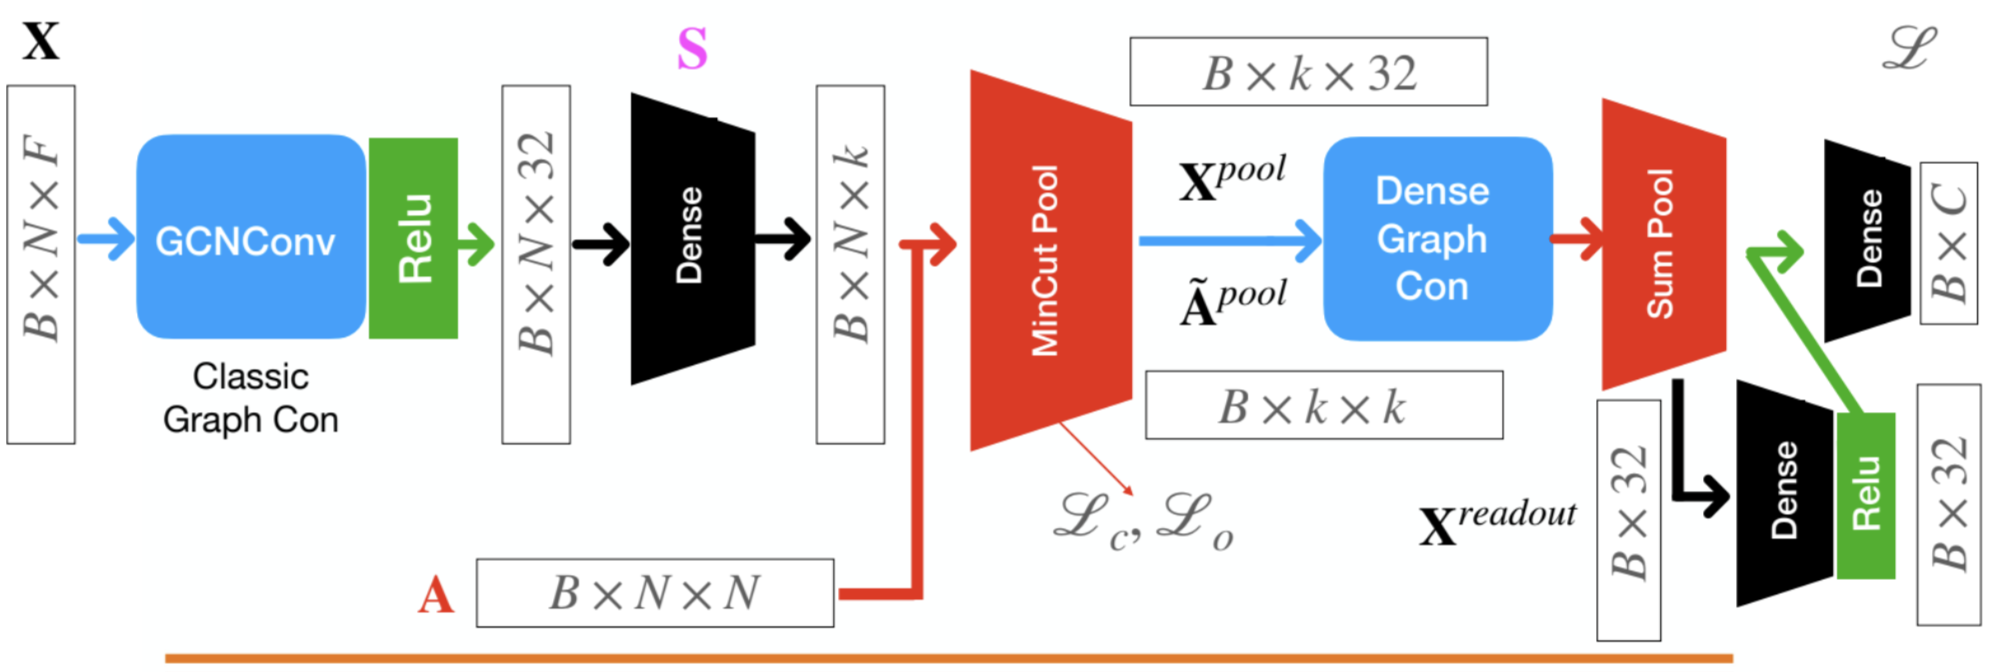

In [31]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super(Net, self).__init__()

        # GCN Layer - MLP - Dense GCN Layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        num_of_centers =  16 # k
        # The degree of the node belonging to any of the centers
        self.pool1 = Linear(hidden_channels, num_of_centers) 
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        # MLPs towards out 
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)
        self.weight = torch.nn.Parameter(torch.zeros(16,32))
        torch.nn.init.normal_(self.weight)
        # Input: Batch of 20 graphs, each node F=3 features 
        #        N1 + N2 + ... + N2 = 661
        # TSNE here?
        self.salidaConv = torch.zeros(0)
    def forward(self, x, edge_index, batch):    # x torch.Size([661, 3]),  data.batch  torch.Size([661])  
        # CONV1: Expand features from F=3 to F' = 32
        x = F.relu(self.conv1(x, edge_index))   # x torch.Size([661, 32]) 
        
        # Make all x_i of size N=MAX(N1,...,N20), e.g. N=40: 
        x, mask = to_dense_batch(x, batch)      # x torch.Size([20, N, 32]) ; mask torch.Size([20, N]) batch_size=20
        #print("x size", x.size())
        
        # Make all adjacencies of size NxN 
        adj = to_dense_adj(edge_index, batch)   # adj torch.Size([20, N, N])
        #print("adj_size", adj.size())
        
        # MLP of k=16 outputs s
        #print("adj_size", adj.size())
        s = self.pool1(x) # s torch.Size([20, N, k])
        #print("s_size", s.size())
        self.salidaConv = s
        # MINCUT_POOL
        # Call to dense_cut_mincut_pool to get coarsened x, adj and the losses: k=16
        x, adj, mincut_loss, ortho_loss = dense_mincut_pool(x, adj, s, mask) # x torch.Size([20, 16, 32]),  adj torch.Size([20, 16, 16])
        #print("Coarsened x and adj sizes:", x.size(), adj.size())

        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #x torch.Size([20, 16, 32])
        #print("x_2 size", x.size())
        
        # Readout for each of the 20 graphs
        #x = x.mean(dim=1) # x torch.Size([20, 32])
        #x = x.sum(dim=1) # x torch.Size([20, 32])
        #x, _ = x.sort(dim=1)
        #x = torch.einsum('nlc, lc -> nc', x, self.weight)
        #print(x.shape)
        #x =  x * self.weight
        #x = x.max(dim=1)[0]
        x = x.max(dim=1)[0]
        #print("mean x_2 size", x.size())
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin1(x)) # x torch.Size([20, 32])
        #print("final x1 size", x.size())
        x = self.lin2(x) #x torch.Size([20, 2])
        #print("final x2 size", x.size())
        return F.log_softmax(x, dim=-1)

## Entrenamiento de 10 ejecuciones  y 50 épocas

In [32]:
def train(epoch):
    model.train()
    loss_all = 0
    k = 0
    nG = 0
    for data in train_loader:
        data = data.to(device)
        #print(data.x.size(), data.edge_index.size(),data.batch.size(), k)
        data
        nG += data.num_graphs
        optimizer.zero_grad()
        out= model(data.x, data.edge_index, data.batch) # data.batch  torch.Size([783])
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
        k = k + 1
    #print("Training graphs per epoch", nG)
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1))
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)


best_val_loss = float('inf')
patience = start_patience = 50
resultados = []
for i in range(10):
    dataset = dataset.shuffle()
    train_dataset = dataset[:150]
    test_dataset = dataset[150:]
    train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(dataset.num_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    for epoch in range(1, 30):
        train_loss = train(epoch)
        _, train_acc = test(train_loader)
        test_loss, test_acc = test(test_loader)
        print('Epoch: {:03d}, '
              'Train Loss: {:.3f}, Train Acc: {:.3f}, '
              'Test Loss: {:.3f}, Test Acc: {:.3f}'.format(epoch, train_loss,
                                                           train_acc,
                                                            test_loss,
                                                           test_acc))
    print(f'RUN:{i},Test Acc:{test_acc:.4f}')
    resultados.append(test_acc)

Epoch: 001, Train Loss: 0.692, Train Acc: 0.660, Test Loss: 0.668, Test Acc: 0.684
Epoch: 002, Train Loss: 0.645, Train Acc: 0.660, Test Loss: 0.631, Test Acc: 0.684
Epoch: 003, Train Loss: 0.602, Train Acc: 0.660, Test Loss: 0.601, Test Acc: 0.684
Epoch: 004, Train Loss: 0.576, Train Acc: 0.660, Test Loss: 0.583, Test Acc: 0.684
Epoch: 005, Train Loss: 0.569, Train Acc: 0.660, Test Loss: 0.578, Test Acc: 0.684
Epoch: 006, Train Loss: 0.562, Train Acc: 0.660, Test Loss: 0.573, Test Acc: 0.684
Epoch: 007, Train Loss: 0.556, Train Acc: 0.660, Test Loss: 0.568, Test Acc: 0.684
Epoch: 008, Train Loss: 0.548, Train Acc: 0.660, Test Loss: 0.564, Test Acc: 0.684
Epoch: 009, Train Loss: 0.542, Train Acc: 0.660, Test Loss: 0.558, Test Acc: 0.684
Epoch: 010, Train Loss: 0.536, Train Acc: 0.660, Test Loss: 0.551, Test Acc: 0.684
Epoch: 011, Train Loss: 0.527, Train Acc: 0.660, Test Loss: 0.546, Test Acc: 0.684
Epoch: 012, Train Loss: 0.519, Train Acc: 0.660, Test Loss: 0.539, Test Acc: 0.684
Epoc

Epoch: 013, Train Loss: 0.534, Train Acc: 0.660, Test Loss: 0.438, Test Acc: 0.816
Epoch: 014, Train Loss: 0.519, Train Acc: 0.707, Test Loss: 0.419, Test Acc: 0.868
Epoch: 015, Train Loss: 0.506, Train Acc: 0.727, Test Loss: 0.395, Test Acc: 0.895
Epoch: 016, Train Loss: 0.493, Train Acc: 0.753, Test Loss: 0.378, Test Acc: 0.895
Epoch: 017, Train Loss: 0.483, Train Acc: 0.787, Test Loss: 0.359, Test Acc: 0.895
Epoch: 018, Train Loss: 0.468, Train Acc: 0.793, Test Loss: 0.346, Test Acc: 0.868
Epoch: 019, Train Loss: 0.461, Train Acc: 0.793, Test Loss: 0.326, Test Acc: 0.868
Epoch: 020, Train Loss: 0.455, Train Acc: 0.793, Test Loss: 0.308, Test Acc: 0.868
Epoch: 021, Train Loss: 0.447, Train Acc: 0.840, Test Loss: 0.309, Test Acc: 0.895
Epoch: 022, Train Loss: 0.433, Train Acc: 0.793, Test Loss: 0.286, Test Acc: 0.868
Epoch: 023, Train Loss: 0.434, Train Acc: 0.840, Test Loss: 0.281, Test Acc: 0.868
Epoch: 024, Train Loss: 0.426, Train Acc: 0.847, Test Loss: 0.283, Test Acc: 0.895
Epoc

Epoch: 026, Train Loss: 0.418, Train Acc: 0.807, Test Loss: 0.273, Test Acc: 0.921
Epoch: 027, Train Loss: 0.414, Train Acc: 0.833, Test Loss: 0.265, Test Acc: 0.947
Epoch: 028, Train Loss: 0.410, Train Acc: 0.833, Test Loss: 0.260, Test Acc: 0.947
Epoch: 029, Train Loss: 0.412, Train Acc: 0.820, Test Loss: 0.254, Test Acc: 0.947
RUN:6,Test Acc:0.9474
Epoch: 001, Train Loss: 0.662, Train Acc: 0.680, Test Loss: 0.677, Test Acc: 0.605
Epoch: 002, Train Loss: 0.617, Train Acc: 0.680, Test Loss: 0.676, Test Acc: 0.605
Epoch: 003, Train Loss: 0.585, Train Acc: 0.680, Test Loss: 0.691, Test Acc: 0.605
Epoch: 004, Train Loss: 0.569, Train Acc: 0.680, Test Loss: 0.702, Test Acc: 0.605
Epoch: 005, Train Loss: 0.566, Train Acc: 0.680, Test Loss: 0.712, Test Acc: 0.605
Epoch: 006, Train Loss: 0.560, Train Acc: 0.680, Test Loss: 0.694, Test Acc: 0.605
Epoch: 007, Train Loss: 0.552, Train Acc: 0.680, Test Loss: 0.677, Test Acc: 0.605
Epoch: 008, Train Loss: 0.545, Train Acc: 0.680, Test Loss: 0.672

In [35]:
res= torch.Tensor(resultados)
print(torch.mean(res))
print(torch.std(res))

tensor(0.8921)
tensor(0.0488)


In [53]:
test_loader = DataLoader(test_dataset[6:], batch_size=1, shuffle=False)
sample = next(iter(test_loader))
#sample.batch =torch.tensor(1)
print(sample)
print(sample.y)
out = model(sample.x,sample.edge_index, sample.batch)  # Perform a single forward pass.
pred = out.argmax(dim=1)  # Use the class with highest probability.
print(pred)
correct = 0
correct += int((pred[0] == sample[0].y).sum())  # Check against ground-truth labels.
print("Accuracy: ",(correct/1)*100)#Batch_size

DataBatch(edge_index=[2, 130], x=[36, 3], y=[1], batch=[36], ptr=[2])
tensor([0])
tensor([0])
Accuracy:  100.0


In [44]:
#https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/
#Nodos criticos
import networkx as nx
Conv_out= model.salidaConv
print(model.salidaConv.shape)
critical_nodes = Conv_out.argmax(1).unique().tolist()
#Pool_out = model.salidaPooling
print(Conv_out.shape)
#print(Pool_out.shape)
print(critical_nodes)
#print(Conv_out)
grafo_init = sample
A = to_networkx(grafo_init, to_undirected=True)
deg_centrality = list(nx.closeness_centrality(A))
print(torch.Tensor(deg_centrality).tolist())

torch.Size([1, 23, 16])
torch.Size([1, 23, 16])
[4, 21]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0]


DataBatch(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1], batch=[23], ptr=[2])


"\nfor node, adjacencies in enumerate(A.nodes()):\n    #print(adjacencies,critical_nodes)\n    if adjacencies in critical_nodes :\n        node_adjacencies.append('rgb(256,0,0)')\n    else:\n        node_adjacencies.append('rgb(0,0,0)')\n    #node_text.append('# of connections: '+str(len(adjacencies[1])))\n    "

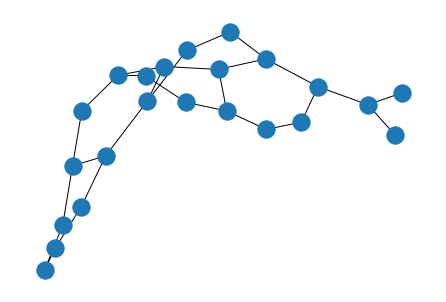

In [45]:

#loader =  DataLoader(dataset, batch_size=1, shuffle=False)
grafo_init = sample
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
#print(N)
layt=G.layout('kk', dim=3)
#print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
#print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)


node_adjacencies = []
node_text = []
'''
for node, adjacencies in enumerate(A.nodes()):
    #print(adjacencies,critical_nodes)
    if adjacencies in critical_nodes :
        node_adjacencies.append('rgb(256,0,0)')
    else:
        node_adjacencies.append('rgb(0,0,0)')
    #node_text.append('# of connections: '+str(len(adjacencies[1])))
    '''

In [46]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             #color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
trace2.marker.color = node_adjacencies
#print(trace2)
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="3D graph visualization of Mutag dataset  by : Ahmed",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',)

In [47]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

## Dataset PROTEINS

In [48]:
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of edges: 162
Average node degree: 3.86
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [49]:
#torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:890]
test_dataset = dataset[890:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 890
Number of test graphs: 223


In [50]:
from torch_geometric.loader import DataLoader



for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 776], x=[351, 7], edge_attr=[776, 4], y=[20], batch=[351], ptr=[21])

Step 2:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 734], x=[336, 7], edge_attr=[734, 4], y=[20], batch=[336], ptr=[21])

Step 3:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 834], x=[375, 7], edge_attr=[834, 4], y=[20], batch=[375], ptr=[21])

Step 4:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 798], x=[359, 7], edge_attr=[798, 4], y=[20], batch=[359], ptr=[21])

Step 5:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 780], x=[360, 7], edge_attr=[780, 4], y=[20], batch=[360], ptr=[21])

Step 6:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 842], x=[373, 7], edge_attr=[842, 4], y=[20], batch=[373], ptr=[21])

Step 7:
Number of graphs in the current batch: 20
DataBatch(edge_index=[2, 808], x=[367, 7], edge_attr=[808, 4], y=[20], batch=[36

## Entrenamiento de 10 ejecuciones y 50 épocas

In [51]:
def train(epoch):
    model.train()
    loss_all = 0
    k = 0
    nG = 0
    for data in train_loader:
        data = data.to(device)
        #print(data.x.size(), data.edge_index.size(),data.batch.size(), k)
        data
        nG += data.num_graphs
        optimizer.zero_grad()
        out= model(data.x, data.edge_index, data.batch) # data.batch  torch.Size([783])
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
        k = k + 1
    #print("Training graphs per epoch", nG)
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1))
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)


best_val_loss = float('inf')
patience = start_patience = 50
for i in range(10):
    dataset = dataset.shuffle()
    train_dataset = dataset[:890]
    test_dataset = dataset[890:]
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(dataset.num_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    for epoch in range(1, 50):
        train_loss = train(epoch)
        _, train_acc = test(train_loader)
        test_loss, test_acc = test(test_loader)
        print('Epoch: {:03d}, '
              'Train Loss: {:.3f}, Train Acc: {:.3f}, '
              'Test Loss: {:.3f}, Test Acc: {:.3f}'.format(epoch, train_loss,
                                                           train_acc,
                                                            test_loss,
                                                           test_acc))
    print(f'RUN:{i},Test Acc:{test_acc:.4f}')
    resultados.append(test_acc)

Epoch: 001, Train Loss: 0.664, Train Acc: 0.597, Test Loss: 0.681, Test Acc: 0.596
Epoch: 002, Train Loss: 0.614, Train Acc: 0.596, Test Loss: 0.716, Test Acc: 0.596
Epoch: 003, Train Loss: 0.605, Train Acc: 0.635, Test Loss: 0.698, Test Acc: 0.650
Epoch: 004, Train Loss: 0.592, Train Acc: 0.698, Test Loss: 0.689, Test Acc: 0.717
Epoch: 005, Train Loss: 0.582, Train Acc: 0.734, Test Loss: 0.689, Test Acc: 0.726
Epoch: 006, Train Loss: 0.572, Train Acc: 0.739, Test Loss: 0.666, Test Acc: 0.744
Epoch: 007, Train Loss: 0.564, Train Acc: 0.744, Test Loss: 0.673, Test Acc: 0.740
Epoch: 008, Train Loss: 0.559, Train Acc: 0.745, Test Loss: 0.668, Test Acc: 0.749
Epoch: 009, Train Loss: 0.551, Train Acc: 0.743, Test Loss: 0.642, Test Acc: 0.744
Epoch: 010, Train Loss: 0.548, Train Acc: 0.738, Test Loss: 0.636, Test Acc: 0.740
Epoch: 011, Train Loss: 0.546, Train Acc: 0.739, Test Loss: 0.608, Test Acc: 0.740
Epoch: 012, Train Loss: 0.539, Train Acc: 0.742, Test Loss: 0.609, Test Acc: 0.749
Epoc

Epoch: 002, Train Loss: 0.629, Train Acc: 0.601, Test Loss: 0.661, Test Acc: 0.574
Epoch: 003, Train Loss: 0.609, Train Acc: 0.601, Test Loss: 0.633, Test Acc: 0.574
Epoch: 004, Train Loss: 0.593, Train Acc: 0.702, Test Loss: 0.599, Test Acc: 0.722
Epoch: 005, Train Loss: 0.578, Train Acc: 0.728, Test Loss: 0.569, Test Acc: 0.767
Epoch: 006, Train Loss: 0.566, Train Acc: 0.746, Test Loss: 0.548, Test Acc: 0.762
Epoch: 007, Train Loss: 0.557, Train Acc: 0.744, Test Loss: 0.533, Test Acc: 0.758
Epoch: 008, Train Loss: 0.546, Train Acc: 0.751, Test Loss: 0.519, Test Acc: 0.776
Epoch: 009, Train Loss: 0.536, Train Acc: 0.747, Test Loss: 0.506, Test Acc: 0.771
Epoch: 010, Train Loss: 0.530, Train Acc: 0.753, Test Loss: 0.489, Test Acc: 0.789
Epoch: 011, Train Loss: 0.524, Train Acc: 0.756, Test Loss: 0.479, Test Acc: 0.794
Epoch: 012, Train Loss: 0.522, Train Acc: 0.757, Test Loss: 0.470, Test Acc: 0.780
Epoch: 013, Train Loss: 0.518, Train Acc: 0.758, Test Loss: 0.465, Test Acc: 0.780
Epoc

Epoch: 003, Train Loss: 0.594, Train Acc: 0.637, Test Loss: 0.699, Test Acc: 0.556
Epoch: 004, Train Loss: 0.585, Train Acc: 0.694, Test Loss: 0.708, Test Acc: 0.637
Epoch: 005, Train Loss: 0.575, Train Acc: 0.728, Test Loss: 0.696, Test Acc: 0.735
Epoch: 006, Train Loss: 0.564, Train Acc: 0.726, Test Loss: 0.721, Test Acc: 0.722
Epoch: 007, Train Loss: 0.560, Train Acc: 0.738, Test Loss: 0.708, Test Acc: 0.722
Epoch: 008, Train Loss: 0.552, Train Acc: 0.739, Test Loss: 0.712, Test Acc: 0.726
Epoch: 009, Train Loss: 0.546, Train Acc: 0.738, Test Loss: 0.725, Test Acc: 0.726
Epoch: 010, Train Loss: 0.542, Train Acc: 0.739, Test Loss: 0.730, Test Acc: 0.753
Epoch: 011, Train Loss: 0.537, Train Acc: 0.745, Test Loss: 0.723, Test Acc: 0.758
Epoch: 012, Train Loss: 0.538, Train Acc: 0.736, Test Loss: 0.698, Test Acc: 0.753
Epoch: 013, Train Loss: 0.534, Train Acc: 0.740, Test Loss: 0.728, Test Acc: 0.767
Epoch: 014, Train Loss: 0.529, Train Acc: 0.746, Test Loss: 0.728, Test Acc: 0.771
Epoc

Epoch: 004, Train Loss: 0.585, Train Acc: 0.735, Test Loss: 0.599, Test Acc: 0.691
Epoch: 005, Train Loss: 0.574, Train Acc: 0.742, Test Loss: 0.578, Test Acc: 0.726
Epoch: 006, Train Loss: 0.565, Train Acc: 0.742, Test Loss: 0.571, Test Acc: 0.740
Epoch: 007, Train Loss: 0.556, Train Acc: 0.743, Test Loss: 0.550, Test Acc: 0.753
Epoch: 008, Train Loss: 0.549, Train Acc: 0.737, Test Loss: 0.545, Test Acc: 0.735
Epoch: 009, Train Loss: 0.544, Train Acc: 0.744, Test Loss: 0.533, Test Acc: 0.744
Epoch: 010, Train Loss: 0.536, Train Acc: 0.744, Test Loss: 0.536, Test Acc: 0.740
Epoch: 011, Train Loss: 0.531, Train Acc: 0.756, Test Loss: 0.511, Test Acc: 0.740
Epoch: 012, Train Loss: 0.525, Train Acc: 0.753, Test Loss: 0.521, Test Acc: 0.744
Epoch: 013, Train Loss: 0.518, Train Acc: 0.752, Test Loss: 0.509, Test Acc: 0.753
Epoch: 014, Train Loss: 0.515, Train Acc: 0.756, Test Loss: 0.507, Test Acc: 0.749
Epoch: 015, Train Loss: 0.512, Train Acc: 0.757, Test Loss: 0.500, Test Acc: 0.753
Epoc

Epoch: 005, Train Loss: 0.570, Train Acc: 0.730, Test Loss: 0.536, Test Acc: 0.704
Epoch: 006, Train Loss: 0.559, Train Acc: 0.743, Test Loss: 0.520, Test Acc: 0.744
Epoch: 007, Train Loss: 0.549, Train Acc: 0.748, Test Loss: 0.507, Test Acc: 0.753
Epoch: 008, Train Loss: 0.545, Train Acc: 0.746, Test Loss: 0.515, Test Acc: 0.744
Epoch: 009, Train Loss: 0.538, Train Acc: 0.743, Test Loss: 0.505, Test Acc: 0.749
Epoch: 010, Train Loss: 0.535, Train Acc: 0.743, Test Loss: 0.508, Test Acc: 0.744
Epoch: 011, Train Loss: 0.528, Train Acc: 0.735, Test Loss: 0.511, Test Acc: 0.740
Epoch: 012, Train Loss: 0.525, Train Acc: 0.746, Test Loss: 0.503, Test Acc: 0.744
Epoch: 013, Train Loss: 0.523, Train Acc: 0.748, Test Loss: 0.491, Test Acc: 0.753
Epoch: 014, Train Loss: 0.517, Train Acc: 0.747, Test Loss: 0.494, Test Acc: 0.753
Epoch: 015, Train Loss: 0.515, Train Acc: 0.751, Test Loss: 0.485, Test Acc: 0.749
Epoch: 016, Train Loss: 0.514, Train Acc: 0.760, Test Loss: 0.493, Test Acc: 0.762
Epoc

In [54]:
res= torch.Tensor(resultados)
print(torch.mean(res))
print(torch.std(res))


tensor(0.8286)
tensor(0.0745)


In [94]:
test_loader = DataLoader(test_dataset[4:], batch_size=1, shuffle=False)
sample = next(iter(test_loader))
#sample.batch =torch.tensor(1) interesantes = 4
print(sample)
print(sample.y)
out = model(sample.x,sample.edge_index, sample.batch)  # Perform a single forward pass.
pred = out.argmax(dim=1)  # Use the class with highest probability.
print(pred)
correct = 0
correct += int((pred[0] == sample[0].y).sum())  # Check against ground-truth labels.
print("Accuracy: ",(correct/1)*100)#Batch_size

DataBatch(edge_index=[2, 74], x=[18, 3], y=[1], batch=[18], ptr=[2])
tensor([0])
tensor([0])
Accuracy:  100.0


In [100]:
#https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/
#Nodos criticos
import networkx as nx
Conv_out= model.salidaConv
print(model.salidaConv.shape)
critical_nodes = Conv_out.argmax(1).unique().tolist()
#Pool_out = model.salidaPooling
print(Conv_out.shape)
#print(Pool_out.shape)
print(critical_nodes)
#print(Conv_out)
grafo_init = sample
A = to_networkx(grafo_init, to_undirected=True)
deg_centrality = list(nx.degree_centrality(A).values())
print(torch.Tensor(deg_centrality).argsort().tolist())
print(critical_nodes)
print(torch.Tensor(deg_centrality).argsort().tolist()[:6])

torch.Size([1, 18, 16])
torch.Size([1, 18, 16])
[0, 4, 5, 8, 14, 15]
[0, 9, 10, 8, 4, 5, 16, 7, 15, 1, 2, 14, 12, 13, 11, 3, 6, 17]
[0, 4, 5, 8, 14, 15]
[0, 9, 10, 8, 4, 5]


DataBatch(edge_index=[2, 130], x=[36, 3], y=[1], batch=[36], ptr=[2])
36
<Layout with 36 vertices and 3 dimensions>
[(0, 1), (0, 2), (0, 17), (1, 2), (1, 18), (2, 3), (2, 4), (2, 17), (2, 18), (2, 19), (2, 20), (3, 4), (3, 18), (4, 5), (4, 20), (5, 6), (5, 21), (6, 7), (7, 8), (7, 9), (7, 23), (8, 9), (8, 24), (9, 32), (10, 11), (10, 32), (10, 33), (10, 35), (11, 12), (11, 33), (12, 13), (12, 14), (12, 26), (13, 14), (13, 15), (14, 15), (15, 16), (16, 30), (16, 31), (17, 18), (18, 19), (18, 20), (19, 20), (20, 21), (21, 22), (22, 23), (22, 24), (23, 24), (24, 34), (25, 26), (25, 33), (25, 35), (26, 27), (27, 28), (27, 29), (28, 29), (28, 30), (29, 30), (29, 31), (30, 31), (32, 33), (32, 35), (33, 34), (33, 35), (34, 35)]


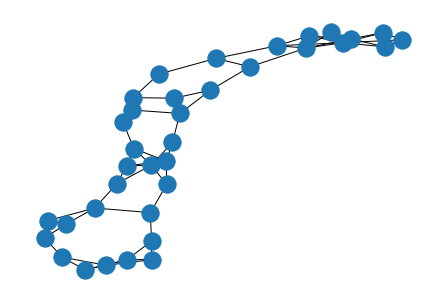

In [90]:
import networkx as nx
from torch_geometric.utils import *
#loader =  DataLoader(dataset, batch_size=1, shuffle=False)
grafo_init = sample
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
print(N)
layt=G.layout('kk', dim=3)
print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)
node_adjacencies = []
node_text = []

for node, adjacencies in enumerate(A.nodes()):
    #print(adjacencies,critical_nodes)
    if adjacencies in critical_nodes :
        node_adjacencies.append('rgb(256,0,0)')
    else:
        node_adjacencies.append('rgb(0,0,0)')
    #node_text.append('# of connections: '+str(len(adjacencies[1])))

In [91]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             #color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
trace2.marker.color = node_adjacencies
#print(trace2)
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',    )

In [92]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

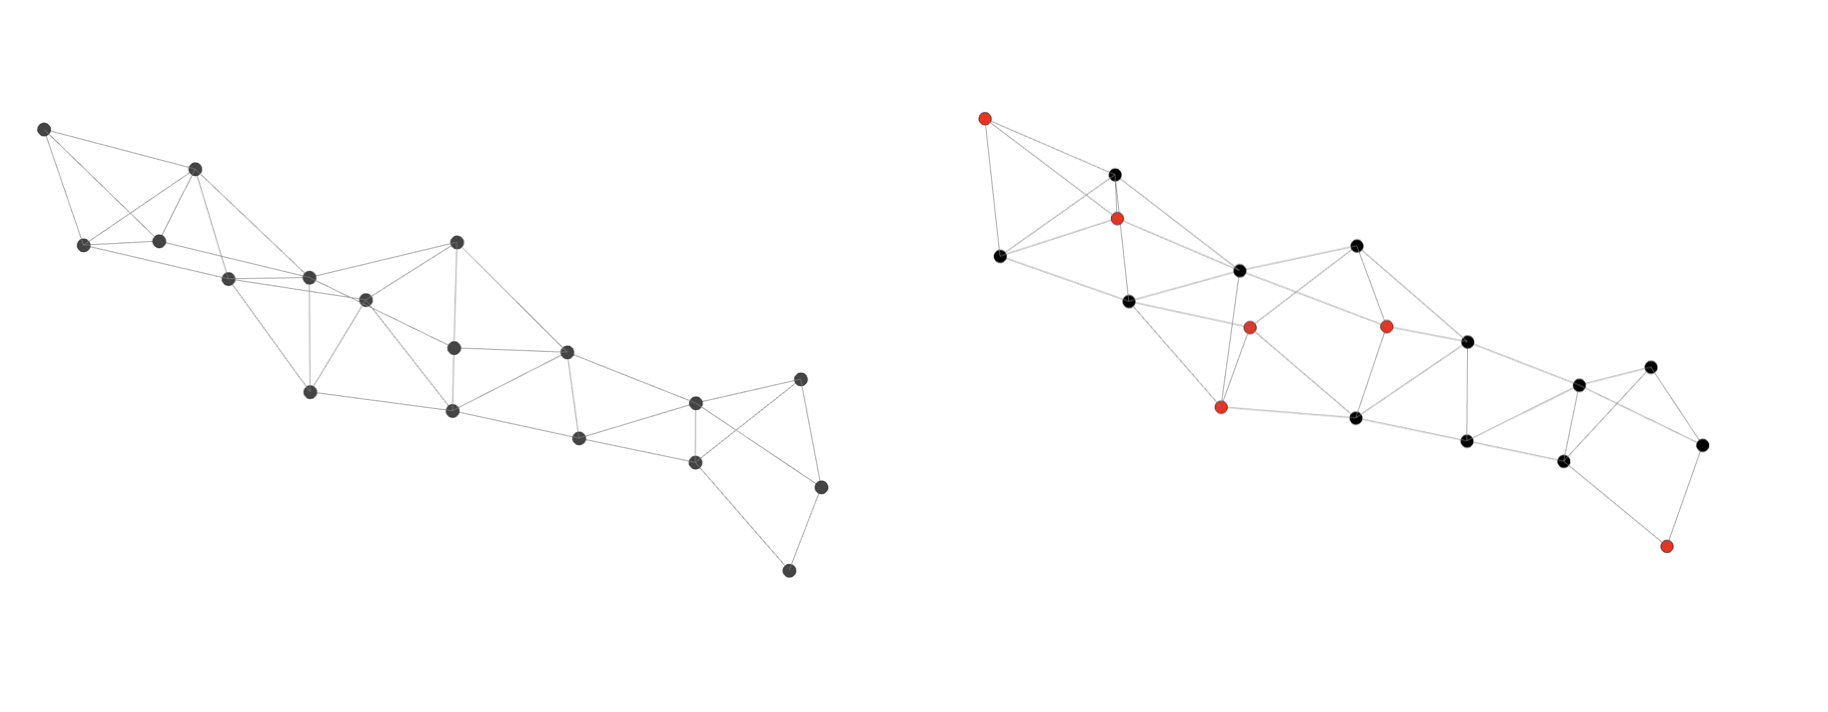